In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install sentence-transformers faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 85.5 MB 107 kB/s 
     |████████████████████████████████| 5.5 MB 46.3 MB/s 
     |████████████████████████████████| 1.3 MB 57.3 MB/s 
     |████████████████████████████████| 182 kB 63.6 MB/s 
     |████████████████████████████████| 7.6 MB 39.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=132a6b58a1a70554f65d00e7550daa357bfbe5dedc02e2de14d5d6528a28f5fb
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
import faiss
from textblob import TextBlob
from sentence_transformers import SentenceTransformer

In [4]:
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
# data = pd.read_csv('./data/wiki_movie_plots_deduped.csv')

# Comment the following lines for local execution
from google.colab import drive
drive.mount('/content/gdrive')


# data = data.iloc[:5000]
# data.info()

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Mounted at /content/gdrive


In [5]:
# Comment this block for local execution
data = pd.read_csv('/content/gdrive/My Drive/NLP/wiki_movie_plots_deduped.csv')
# data = pd.read_csv('/content/gdrive/My Drive/Projects/NLP Project/wiki_movie_plots_deduped.csv')
data = data.iloc[:5000]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      5000 non-null   int64 
 1   Title             5000 non-null   object
 2   Origin/Ethnicity  5000 non-null   object
 3   Director          5000 non-null   object
 4   Cast              4895 non-null   object
 5   Genre             5000 non-null   object
 6   Wiki Page         5000 non-null   object
 7   Plot              5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


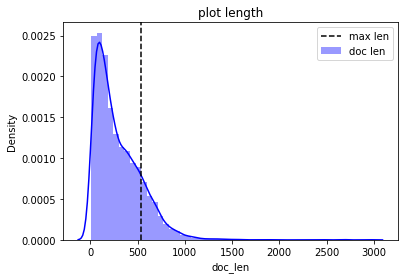

In [6]:
data = data[['Title', 'Plot']]
data.dropna(inplace=True)
data.drop_duplicates(subset=['Plot'], inplace=True)

data['doc_len'] = data['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(data['doc_len'].mean() + data['doc_len'].std()).astype(int)
sns.distplot(data['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [7]:
encoded_data = model.encode(data.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data))))
faiss.write_index(index, 'movie_plot.index')

In [8]:
def fetch_movie_info(dataframe_idx):
    info = data.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [9]:
from pprint import pprint

# query="Artificial Intelligence based action movie"
query="movie about romance and pain of separation"
results=search(query, top_k=3, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.02433180809020996


	 {'Title': 'City Without Men'}
	 {'Title': 'So Proudly We Hail!'}
	 {'Title': 'Red Light'}


In [10]:
def _removeNonAscii(s): 
  return "".join(i for i in s if ord(i) < 128)

In [11]:
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query
paragraphs=data.Plot.tolist()

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model.eval()

In [ ]:
device = 'cuda'
model.to(device)

In [14]:
# run this only once to generate synthetic queries

# from tqdm import tqdm

# with open('generated_queries_all.tsv', 'w') as fOut:
#     for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
#         sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
#         inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
#         outputs = model.generate(
#             **inputs,
#             max_length=max_length_query,
#             do_sample=True,
#             top_p=0.95,
#             num_return_sequences=num_queries)

#         for idx, out in enumerate(outputs):
#             query = tokenizer.decode(out, skip_special_tokens=True)
#             query = _removeNonAscii(query)
#             para = sub_paragraphs[int(idx/num_queries)]
#             para = _removeNonAscii(para)
#             fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

In [16]:
# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os

train_examples = [] 
with open('/content/gdrive/MyDrive/NLP/generated_queries_all.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)

In [18]:
#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)



Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3108 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3108 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3108 [00:00<?, ?it/s]

In [19]:
os.makedirs('/content/gdrive/MyDrive/NLP/search', exist_ok=True)
model.save('/content/gdrive/MyDrive/NLP/search/search-model')

In [20]:
model = SentenceTransformer('/content/gdrive/MyDrive/NLP/search/search-model')

In [22]:
!zip -r search_model.zip "/content/gdrive/MyDrive/NLP/search"

  adding: content/gdrive/MyDrive/NLP/search/ (stored 0%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/ (stored 0%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/config_sentence_transformers.json (deflated 26%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/config.json (deflated 44%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/pytorch_model.bin (deflated 8%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/tokenizer_config.json (deflated 44%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/special_tokens_map.json (deflated 42%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/vocab.txt (deflated 53%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/tokenizer.json (deflated 71%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/sentence_bert_config.json (deflated 4%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/1_Pooling/ (stored 0%)
  adding: content/gdrive/MyDrive/NLP/search/search-model/1

In [23]:
encoded_data = model.encode(data.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data))))
faiss.write_index(index, 'movie_plot.index')

In [26]:
from pprint import pprint

query="movie about romance and pain of seperation"
results=search(query, top_k=3, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.026006221771240234


	 {'Title': 'The Suburbanite'}
	 {'Title': 'Westward Passage'}
	 {'Title': 'So Proudly We Hail!'}
